In [29]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

TEAM_CODE = {
    "OpTic Texas": "TX", "FaZe Vegas": "FV", "G2 Minnesota": "MIN",
    "Paris Gentle Mates": "M8", "Los Angeles Thieves": "LAT",
    "Carolina Royal Ravens": "CAR", "Miami Heretics": "MIA",
    "Boston Breach": "BOS", "Riyadh Falcons": "RYD",
    "Cloud9 New York": "C9NY", "Toronto KOI": "TOR", "Vancouver Surge": "VAN",
}

# ── Load all 3 CSVs ─────────────────────────────────────────────────
ts = pd.read_csv("team_stats.csv").set_index("Team").apply(pd.to_numeric, errors="coerce").fillna(0)
players = pd.read_csv("player_stats.csv").merge(pd.read_csv("team_roster.csv"), on="Player")
num_cols = players.select_dtypes("number").columns.drop(["Index"], errors="ignore")
for c in num_cols:
    players[c] = pd.to_numeric(players[c].astype(str).str.rstrip("%"), errors="coerce").fillna(0)
player_agg = players.groupby("team_code")[num_cols].mean()

# ── Build matchup features from team_stats + player_stats ────────
teams = list(ts.index)

def build_row(ca, cb):
    """Build feature row: team stat diffs + player aggregate diffs."""
    t = (ts.loc[ca] - ts.loc[cb]).add_prefix("t_")
    p = (player_agg.reindex([ca, cb]).fillna(0))
    p_diff = (p.loc[ca] - p.loc[cb]).rename(lambda c: c.replace("/","_").replace(" ","_")).add_prefix("p_")
    return pd.concat([t, p_diff])

# ── Generate training data from every team pair ──────────────────
# Use mode-specific win rates as proxy for "who wins"
# A team with higher combined win% across modes is more likely to win the series
rows, labels = [], []
for i, ca in enumerate(teams):
    for cb in teams:
        if ca == cb:
            continue
        row = build_row(ca, cb)
        rows.append(row)
        # label: does team A have a higher combined mode win% than team B?
        a_str = (ts.loc[ca, "HP_Win_Percent"] + ts.loc[ca, "SND_Win_Percent"] + ts.loc[ca, "OVL_Win_Percent"]) / 3
        b_str = (ts.loc[cb, "HP_Win_Percent"] + ts.loc[cb, "SND_Win_Percent"] + ts.loc[cb, "OVL_Win_Percent"]) / 3
        labels.append(1 if a_str > b_str else 0)

X = pd.DataFrame(rows).fillna(0)
y = np.array(labels)
feat = list(X.columns)

# Scale
scaler = StandardScaler().fit(X)
Xs = pd.DataFrame(scaler.transform(X), columns=feat)

# ── Test all models ─────────────────────────────────────────────────
models = {
    "Logistic Regression": LogisticRegression(C=0.5, max_iter=1000, random_state=42),
    "Random Forest":       RandomForestClassifier(n_estimators=100, max_depth=3, min_samples_leaf=3, random_state=42),
    "Gradient Boosting":   GradientBoostingClassifier(n_estimators=50, max_depth=2, learning_rate=0.1, min_samples_leaf=3, random_state=42),
    "SVM (RBF)":           SVC(kernel="rbf", C=1, probability=True, random_state=42),
    "SVM (Linear)":        SVC(kernel="linear", C=0.5, probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes":         GaussianNB(),
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
print(f"Training on {len(X)} matchups ({len(teams)} teams), {len(feat)} features")
print(f"\n{'Model':<22} {'Accuracy':>8}  {'Std':>5}")
print("-" * 40)
best_name, best_score, best_model = "", 0, None
for name, model in models.items():
    scores = cross_val_score(model, Xs, y, cv=cv, scoring="accuracy")
    print(f"{name:<22} {scores.mean():>7.0%}  +/-{scores.std():>4.0%}")
    if scores.mean() > best_score:
        best_name, best_score, best_model = name, scores.mean(), model

print(f"\nBest: {best_name} ({best_score:.0%})")

# Train best model on all data
best_model.fit(Xs, y)
print(f"Model ready.")

Training on 132 matchups (12 teams), 55 features

Model                  Accuracy    Std
----------------------------------------
Logistic Regression        94%  +/-  4%
Random Forest              90%  +/-  6%
Gradient Boosting          90%  +/-  6%
SVM (RBF)                  91%  +/-  5%
SVM (Linear)               95%  +/-  4%
K-Nearest Neighbors        89%  +/-  6%
Naive Bayes                88%  +/-  6%

Best: SVM (Linear) (95%)
Model ready.


In [30]:
# ── Predict function: map-by-map Bo5 simulation ─────────────────
MAP_ORDER = ["HP", "SND", "OVL", "HP", "SND"]

def mode_win_prob(ca, cb, mode):
    """P(team A wins a map) for a given mode. Sharper formula = more 3-0 and 3-2."""
    a, b = ts.loc[ca], ts.loc[cb]
    pa = player_agg.loc[ca] if ca in player_agg.index else pd.Series(dtype=float)
    pb = player_agg.loc[cb] if cb in player_agg.index else pd.Series(dtype=float)

    if mode == "HP":
        wa, wb = a["HP_Win_Percent"], b["HP_Win_Percent"]
        ka, kb = a["HP_KD"], b["HP_KD"]
        pa_k = pa.get("HP K/10m", 24); pb_k = pb.get("HP K/10m", 24)
        pm_a, pm_b = a["HP_PlusMinus"], b["HP_PlusMinus"]
    elif mode == "SND":
        wa, wb = a["SND_Win_Percent"], b["SND_Win_Percent"]
        ka, kb = a["SND_KD"], b["SND_KD"]
        pa_k = pa.get("SND KpR", 0.7); pb_k = pb.get("SND KpR", 0.7)
        pm_a, pm_b = a["SND_PlusMinus"], b["SND_PlusMinus"]
    else:
        wa, wb = a["OVL_Win_Percent"], b["OVL_Win_Percent"]
        ka, kb = a["OVL_KD"], b["OVL_KD"]
        pa_k = pa.get("OVL K/10m", 22); pb_k = pb.get("OVL K/10m", 22)
        pm_a, pm_b = a["OVL_Round_PlusMinus"], b["OVL_Round_PlusMinus"]

    # Sharper win-rate: steeper curve so dominant teams get 70–85% map win (3-0 becomes mode)
    wr_diff = (wa - wb) / 18
    wr = 0.5 + 0.45 * np.tanh(wr_diff)

    # KD ratio: log scale so 1.2 vs 0.9 matters more
    kd_ratio = np.log(ka / kb + 0.1) if kb > 0 else 0
    kd = 1 / (1 + np.exp(-kd_ratio))

    # Plus/minus: big gap = strong signal
    pm = 1 / (1 + np.exp(-(pm_a - pm_b) / 8))

    # Player skill
    pk = 1 / (1 + np.exp(-(pa_k - pb_k) / 1.5))

    # Slightly more weight on win% so lopsided matchups push map prob higher
    prob = 0.40 * wr + 0.23 * kd + 0.18 * pm + 0.19 * pk
    return np.clip(prob, 0.15, 0.92)  # allow high map prob so 3-0 can be most likely

def simulate_bo5(ca, cb, n=10000):
    """Monte Carlo Bo5: HP, SND, OVL, HP, SND. First to 3.
    Returns full score distribution for both teams.
    Keys: 'A_3_0', 'A_3_1', 'A_3_2', 'B_3_0', 'B_3_1', 'B_3_2'.
    """
    probs = [mode_win_prob(ca, cb, m) for m in MAP_ORDER]
    rng = np.random.default_rng(42)
    counts = {k: 0 for k in [
        "A_3_0", "A_3_1", "A_3_2",
        "B_3_0", "B_3_1", "B_3_2",
    ]}
    for _ in range(n):
        a = b = 0
        for p in probs:
            if rng.random() < p:
                a += 1
            else:
                b += 1
            if a == 3 or b == 3:
                break
        if a == 3:
            if b == 0:   counts["A_3_0"] += 1
            elif b == 1: counts["A_3_1"] += 1
            else:        counts["A_3_2"] += 1
        else:
            if a == 0:   counts["B_3_0"] += 1
            elif a == 1: counts["B_3_1"] += 1
            else:        counts["B_3_2"] += 1
    total = float(n)
    return {k: v / total for k, v in counts.items()}


def predict(team_a, team_b):
    """Return dict with winner, loser, score, win_prob, hp, snd, ovl. If invalid teams, returns dict with error key."""
    if team_a not in TEAM_CODE or team_b not in TEAM_CODE:
        return {"error": f"Unknown team. Use: {list(TEAM_CODE)}"}
    ca, cb = TEAM_CODE[team_a], TEAM_CODE[team_b]

    row = build_row(ca, cb)
    Xp = pd.DataFrame(scaler.transform(pd.DataFrame([row])[feat]), columns=feat)
    ml_prob = best_model.predict_proba(Xp)[0][1]

    dist = simulate_bo5(ca, cb)
    pA_sim = dist["A_3_0"] + dist["A_3_1"] + dist["A_3_2"]
    final = 0.5 * ml_prob + 0.5 * pA_sim

    if final >= 0.5:
        side_keys = ["A_3_0", "A_3_1", "A_3_2"]
        winner, loser = team_a, team_b
        win_prob = final
    else:
        side_keys = ["B_3_0", "B_3_1", "B_3_2"]
        winner, loser = team_b, team_a
        win_prob = 1 - final

    best_key = max(side_keys, key=lambda k: dist[k])
    _, w_str, l_str = best_key.split("_")
    ws, ls = int(w_str), int(l_str)
    score_str = f"{ws}-{ls}"
    score_prob = dist[best_key]

    hp  = mode_win_prob(ca, cb, "HP")
    snd = mode_win_prob(ca, cb, "SND")
    ovl = mode_win_prob(ca, cb, "OVL")

    return {
        "matchup": f"{team_a} vs {team_b}",
        "winner": winner,
        "loser": loser,
        "score": score_str,
        "win_prob": win_prob,
        "score_prob": score_prob,
        "hp": hp, "snd": snd, "ovl": ovl,
    }


def predict_str(team_a, team_b):
    """One-line string for backward compatibility."""
    r = predict(team_a, team_b)
    if "error" in r:
        return r["error"]
    return f"{r['winner']} {r['score']} {r['loser']} ({r['win_prob']:.0%})  [HP:{r['hp']:.0%} SND:{r['snd']:.0%} OVL:{r['ovl']:.0%}]"

print("Ready. predict(team_a, team_b) -> dict | predict_str(team_a, team_b) -> string")
print(f"Teams: {list(TEAM_CODE)}")

Ready. predict(team_a, team_b) -> dict | predict_str(team_a, team_b) -> string
Teams: ['OpTic Texas', 'FaZe Vegas', 'G2 Minnesota', 'Paris Gentle Mates', 'Los Angeles Thieves', 'Carolina Royal Ravens', 'Miami Heretics', 'Boston Breach', 'Riyadh Falcons', 'Cloud9 New York', 'Toronto KOI', 'Vancouver Surge']


In [39]:
# Major II Qualifier Predictions — full schedule (team_a, team_b, when)
matchups = [
    ("OpTic Texas", "Boston Breach", "~3 days"),
    ("Toronto KOI", "Carolina Royal Ravens", "~3 days"),
    ("Miami Heretics", "FaZe Vegas", "~3 days"),
    ("Riyadh Falcons", "Paris Gentle Mates", "~4 days"),
    ("OpTic Texas", "G2 Minnesota", "~4 days"),
    ("Toronto KOI", "FaZe Vegas", "~4 days"),
    ("Vancouver Surge", "Los Angeles Thieves", "~4 days"),
    ("Paris Gentle Mates", "Miami Heretics", "~5 days"),
    ("Riyadh Falcons", "Boston Breach", "~5 days"),
    ("Los Angeles Thieves", "Carolina Royal Ravens", "~5 days"),
    ("G2 Minnesota", "Cloud9 New York", "~5 days"),
    ("Vancouver Surge", "FaZe Vegas", "~10 days"),
    ("Riyadh Falcons", "Cloud9 New York", "~10 days"),
    ("Toronto KOI", "Los Angeles Thieves", "~10 days"),
    ("Toronto KOI", "G2 Minnesota", "~11 days"),
    ("Los Angeles Thieves", "Boston Breach", "~11 days"),
    ("Paris Gentle Mates", "Carolina Royal Ravens", "~11 days"),
    ("OpTic Texas", "Miami Heretics", "~11 days"),
    ("Riyadh Falcons", "Carolina Royal Ravens", "~12 days"),
    ("Vancouver Surge", "Boston Breach", "~12 days"),
    ("OpTic Texas", "Cloud9 New York", "~12 days"),
    ("G2 Minnesota", "FaZe Vegas", "~12 days"),
    ("Carolina Royal Ravens", "Boston Breach", "~17 days"),
    ("Riyadh Falcons", "FaZe Vegas", "~17 days"),
    ("Paris Gentle Mates", "Cloud9 New York", "~17 days"),
    ("Riyadh Falcons", "G2 Minnesota", "~18 days"),
    ("Toronto KOI", "Miami Heretics", "~18 days"),
    ("Vancouver Surge", "Carolina Royal Ravens", "~18 days"),
    ("OpTic Texas", "Los Angeles Thieves", "~18 days"),
    ("Toronto KOI", "Paris Gentle Mates", "~19 days"),
    ("FaZe Vegas", "Boston Breach", "~19 days"),
    ("Miami Heretics", "Cloud9 New York", "~19 days"),
    ("Vancouver Surge", "OpTic Texas", "~19 days"),
    ("Vancouver Surge", "Cloud9 New York", "~24 days"),
    ("Los Angeles Thieves", "FaZe Vegas", "~24 days"),
    ("Miami Heretics", "G2 Minnesota", "~24 days"),
    ("Paris Gentle Mates", "G2 Minnesota", "~25 days"),
    ("OpTic Texas", "FaZe Vegas", "~25 days"),
    ("Toronto KOI", "Riyadh Falcons", "~25 days"),
    ("Cloud9 New York", "Boston Breach", "~25 days"),
    ("Miami Heretics", "Los Angeles Thieves", "~26 days"),
    ("Toronto KOI", "Boston Breach", "~26 days"),
    ("OpTic Texas", "Carolina Royal Ravens", "~26 days"),
    ("Vancouver Surge", "Paris Gentle Mates", "~26 days"),
    ("Toronto KOI", "Cloud9 New York", "~1 month"),
    ("Riyadh Falcons", "Miami Heretics", "~1 month"),
    ("Paris Gentle Mates", "OpTic Texas", "~1 month"),
    ("G2 Minnesota", "Carolina Royal Ravens", "~1 month"),
    ("Vancouver Surge", "Toronto KOI", "~1 month"),
    ("Los Angeles Thieves", "Cloud9 New York", "~1 month"),
]

rows = []
for a, b, when in matchups:
    r = predict(a, b)
    if "error" in r:
        rows.append({"When": when, "Matchup": f"{a} vs {b}", "Winner": r["error"], "Score": "", "Win %": "", "Score prob": "", "HP": "", "SND": "", "OVL": ""})
        continue
    # HP/SND/OVL from winner's perspective (predict returns probs for team A = first team)
    if r["winner"] == a:
        hp, snd, ovl = r["hp"], r["snd"], r["ovl"]
    else:
        hp, snd, ovl = 1 - r["hp"], 1 - r["snd"], 1 - r["ovl"]
    rows.append({
        "When": when,
        "Matchup": r["matchup"],
        "Winner": r["winner"],
        "Score": r["score"],
        "Win %": f"{r['win_prob']:.0%}",
        "HP": f"{hp:.0%}",
        "SND": f"{snd:.0%}",
        "OVL": f"{ovl:.0%}",
    })

# Insert a "Week 1", "Week 2", ... separator row before each week's matchups
when_to_week = {
    "~3 days": "Week 1", "~4 days": "Week 1", "~5 days": "Week 1",
    "~10 days": "Week 2", "~11 days": "Week 2", "~12 days": "Week 2",
    "~17 days": "Week 3", "~18 days": "Week 3", "~19 days": "Week 3",
    "~24 days": "Week 4", "~25 days": "Week 4", "~26 days": "Week 4",
    "~1 month": "Week 5",
}
week_order = ["Week 1", "Week 2", "Week 3", "Week 4", "Week 5"]
display_rows = []
for week in week_order:
    display_rows.append({"Matchup": week, "Winner": "", "Score": "", "Win %": "", "HP": "", "SND": "", "OVL": ""})
    for r in rows:
        w = when_to_week.get(r.get("When", ""), "Week 1")
        if w == week:
            display_rows.append({"Matchup": r["Matchup"], "Winner": r["Winner"], "Score": r["Score"], "Win %": r.get("Win %", ""), "HP": r.get("HP", ""), "SND": r.get("SND", ""), "OVL": r.get("OVL", "")})

df = pd.DataFrame(display_rows)
df.index = range(1, len(df) + 1)
df.index.name = "#"
display(df.style.set_properties(**{"text-align": "left"}).set_table_styles([
    {"selector": "th", "props": [("text-align", "left")]},
]))

,Matchup,Winner,Score,Win %,HP,SND,OVL
#,,,,,,,
1,Week 1,,,,,,
2,OpTic Texas vs Boston Breach,OpTic Texas,3-1,91%,74%,65%,65%
3,Toronto KOI vs Carolina Royal Ravens,Carolina Royal Ravens,3-2,65%,34%,67%,39%
4,Miami Heretics vs FaZe Vegas,FaZe Vegas,3-1,85%,58%,60%,68%
5,Riyadh Falcons vs Paris Gentle Mates,Paris Gentle Mates,3-1,79%,80%,57%,37%
6,OpTic Texas vs G2 Minnesota,OpTic Texas,3-1,82%,53%,58%,71%
7,Toronto KOI vs FaZe Vegas,FaZe Vegas,3-1,86%,58%,69%,59%
8,Vancouver Surge vs Los Angeles Thieves,Los Angeles Thieves,3-0,94%,80%,69%,70%
9,Paris Gentle Mates vs Miami Heretics,Paris Gentle Mates,3-1,87%,80%,61%,41%


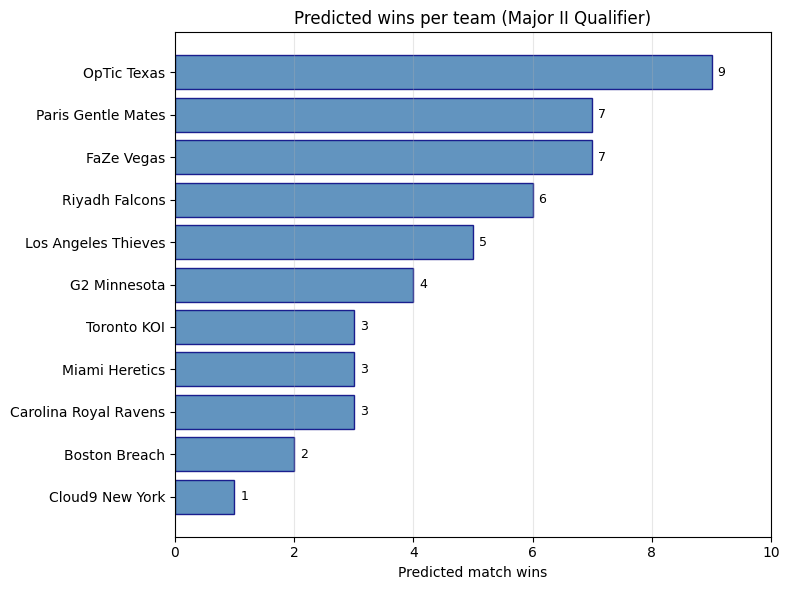

In [34]:
# Visualize predictions (run after the table cell so `df` exists)
import matplotlib.pyplot as plt

valid = df["Win %"].str.strip() != ""
win_pct = df.loc[valid, "Win %"].str.rstrip("%").astype(float) / 100
matchup_labels = df.loc[valid, "Matchup"].str.replace(" vs ", "\nvs\n")

# Graph 1: Predicted wins per team
winner_counts = df.loc[valid, "Winner"].value_counts().sort_values(ascending=True)
fig1, ax1 = plt.subplots(figsize=(8, 6))
bars = ax1.barh(winner_counts.index, winner_counts.values, color="steelblue", edgecolor="navy", alpha=0.85)
ax1.set_xlabel("Predicted match wins")
ax1.set_title("Predicted wins per team (Major II Qualifier)")
ax1.set_xlim(0, winner_counts.max() + 1)
for b in bars:
    ax1.text(b.get_width() + 0.1, b.get_y() + b.get_height()/2, f"{int(b.get_width())}", va="center", fontsize=9)
ax1.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()